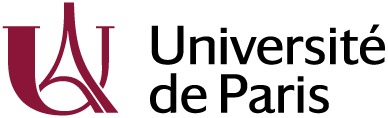
## M2 VMI - TP AD: Object detection using CNNs - Facemasks

Sylvain Lobry, 2020

Completed/Improved by Lilian Bour

In this lab we are going to train a model to detect if people are (correctly) wearing face masks. As data, we will use [one of the datasets available on Kaggle](https://www.kaggle.com/andrewmvd/face-mask-detection).

## 1) Loading the data
You can get the data [from kaggle](https://www.kaggle.com/andrewmvd/face-mask-detection) directly, or through my [Google Drive](https://drive.google.com/drive/folders/1oxP0ept0pmOgjl1BbYaUj9Cf_X7FnI2A?usp=sharing). Then, copy it to your drive.

Now, you need to mount your drive in this VM. This is done by executing the following two lines. You will need to authorize google collab to access to your drive (it will ask you to open a link and give you a confirmation code that you will have to copy on the text field bellow).

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Now find the path to your data:

In [ ]:
data_folder = '/content/drive/MyDrive/Data' 
root_folder = '/content/drive/MyDrive'

## 2) Understanding the data format
In the data folder, you have 2 sub-folders:


1.   images
2.   annotations

The images are in the png format, and the annotations are in the xml format.

**Question 1:** Open an xml file, and try to understand the information it contains and describe it. From this xml, can you guess what bounding box format is used in this dataset? 

**Answer 1 :** The fortmat used is (x,y) of top left and bottom right corners because we don't have any values about width and height. Moreover we have the x and y values, they will be used to determine  the 4 corners of the bounding box.


Let's parse one XML:

In [ ]:
import os
import xml.etree.ElementTree as ET

def get_objects(xml_file):
  annotation = ET.parse(xml_file)
  root = annotation.getroot()

  objects = []
  for obj in root.findall('object'):
    new_object = {'name': obj.find('name').text}
    bbox_tree = obj.find('bndbox')
    new_object['bbox'] = [int(bbox_tree.find('xmin').text),int(bbox_tree.find('ymin').text),int(bbox_tree.find('xmax').text),int(bbox_tree.find('ymax').text)]
    #print(int(bbox_tree.find('xmax').text)-int(bbox_tree.find('xmin').text),'  ',int(bbox_tree.find('ymax').text)-int(bbox_tree.find('ymin').text))
    objects.append(new_object)
  return objects

and show the bounding boxes on one image:

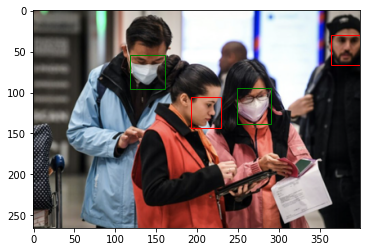

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Color of the bounding boxes (depending on the class)
classes_color = {'with_mask':'g', 'without_mask':'r', 'mask_weared_incorrect':'tab:orange'}
classes_index = {'with_mask':1, 'without_mask':2, 'mask_weared_incorrect':3} #0 is for background

def show_bboxes(image, objects):
  fig,ax = plt.subplots(1)
  ax.imshow(image)

  for annotation in objects:
    xmin, ymin, xmax, ymax = annotation['bbox']
    rect = patches.Rectangle((xmin,ymin), (xmax-xmin), (ymax-ymin), linewidth=1, edgecolor=classes_color[annotation['name']], facecolor='none')
    ax.add_patch(rect)
  plt.show()

#5,7,11
index = 5
objects = get_objects(os.path.join(data_folder, 'annotations', 'maksssksksss' + str(index) + '.xml'))
image = plt.imread(os.path.join(data_folder, 'images', 'maksssksksss' + str(index) + '.png'))
show_bboxes(image, objects)

**Question 2:** We are going to learn from this data. By looking at it, can you find possible biases in it?

**Answer 2:** For example we can see on the 5th image, that the person in the background is blurred because of the depth of field. As a result the person has not be labeled as a person without mask. In the image 7, the person in the backgound has been identified as a person without mask but it's very small, so it's difficult to say. For the 11th image, we can see on the top right corner, a green bounding box, but it doesn't seem to contain anything. 
We can conclude that the model will probably struggle with people in the background because it is unclear, and even we as humain struggle to say if the person is wearing a mask or not. Furthermore, it may be difficiculte for the model to differientiate a poorly worn mask from a well worn mask because most of the time, it is because we can see the nose, it would means that the model will have to "recognise" the noses, which may be difficile if the person is not in the foreground for instance. 

## 3) Creating the dataset class

Now, we need to create a class derived from pytorch's Dataset class able to understand or data format. Since the datasert is not too big, we can load it entirely in RAM.

In [ ]:
from torch.utils.data import Dataset
import torchvision.transforms as T
from tqdm.notebook import tqdm
from PIL import Image

class FaceMaskDataset(Dataset):
  def __init__(self, img_folder, annotation_folder, indexes, conversion=T.ToTensor()):
    self.conversion = conversion
    
    self.dataset = []
    for index in tqdm(indexes):
      sample = {}
      sample['image'] = Image.open(os.path.join(data_folder, 'images', 'maksssksksss' + str(index) + '.png')).convert('RGB')
      sample['objects'] = get_objects(os.path.join(data_folder, 'annotations', 'maksssksksss' + str(index) + '.xml'))
      sample['id'] = index
      self.dataset.append(sample)
    
  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    target = {'boxes': [], 'labels': []}
    for obj in self.dataset[idx]['objects']:
      target["boxes"].append(obj['bbox'])
      target['labels'].append(classes_index[obj['name']])
      
    target["boxes"] = torch.as_tensor(target["boxes"], dtype=torch.float32)
    target["labels"] = torch.as_tensor(target['labels'], dtype=torch.int64)
    target["image_id"] = torch.tensor([self.dataset[idx]['id']])

    img = self.dataset[idx]['image']
    if self.conversion is not None:
      img = self.conversion(img)
    return img, target

And we can create the datasets.

**Question 3:** What is the total number of samples that we have? Does that seem sufficient to train a model? What strategy could we use for training? 

**Answer 3:** We have 852 images, this seems low compared to other dataset such as CIFAR10. We could either add a Fine tuning step or use Data augmentation to overcome this issue. Here we'll use data augmentation with random horizontal flips and random rotations. Further more the data will be split as follows : 


*   Train : 60%
*   Validation : 20%
*   Test : 20%




In [ ]:
import random
import torch
import PIL

train_split_percentage = 0.6
val_split_percentage = 0.2
test_split_percentage = 0.2
size_of_the_dataset = 852

indexes = list(range(size_of_the_dataset))
random.shuffle(indexes)

train_indexes = indexes[:int(train_split_percentage*len(indexes))]
val_indexes = indexes[int(train_split_percentage*len(indexes)):int((train_split_percentage + val_split_percentage)*len(indexes))]
test_indexes = indexes[int((train_split_percentage + val_split_percentage)*len(indexes)):]

print(f"Effective train split = {len(train_indexes)/len(indexes)*100}%")
print(f"Effective val split = {len(val_indexes)/len(indexes)*100}%")
print(f"Effective test split = {len(test_indexes)/len(indexes)*100}%", flush=True)

# From https://github.com/pytorch/vision/blob/ce342580f3ae3f937fa5389c48b82a827b4804df/references/detection/utils.py#L235
def collate_fn(batch):
    return tuple(zip(*batch))

#Data Augmentation
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    return T.Compose(transforms)

batch_size = 2
print("Loading training set")
train_dataset = FaceMaskDataset(os.path.join(data_folder, 'images'), os.path.join(data_folder, 'annotations'), train_indexes, conversion=get_transform(True))
print("Loading validation set")
val_dataset = FaceMaskDataset(os.path.join(data_folder, 'images'), os.path.join(data_folder, 'annotations'), val_indexes, conversion=get_transform(False))
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn=collate_fn)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=collate_fn)

Effective train split = 59.97652582159625%
Effective val split = 19.953051643192488%
Effective test split = 20.070422535211268%
Loading training set



Loading validation set


One thing which is always important is to check the data. At the sample size, we have already seen how to check that we understood the data format, and checked a few samples for corectness. At a larger scale, it is often a good idea to check the labels' distribution.

**Question 4:** Propose and implement a methodology to check the labels' distribution. Discuss your findings.

**Answer 4:** As we can see there is a lot more data labeled as 'with masks' than 'without masks' or 'unsure'. It means that we may have a biais toward the first label because it's more prominent. 

With masks :  1913 
Without masks :  466 
Unsure :  75


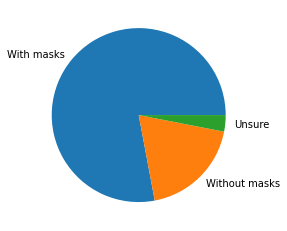

In [ ]:
import matplotlib.pyplot as plt
ones=0
twos=0
threes=0
for i in range(len(train_dataset)):
  for lab in train_dataset[i][1]['labels']:
    if lab.item() == 1:
      ones = ones + 1
    if lab.item() == 2:
      twos = twos + 1
    if lab.item() == 3:
      threes = threes + 1

data=[ones,twos,threes]
print('With masks : ',ones,'\nWithout masks : ',twos,'\nUnsure : ',threes)
labs = ['With masks', 'Without masks', 'Unsure'] 
plt.pie(data, labels = labs) 
plt.show() 


## 4) Defining the model

For this project, we propose to take a pre-trained Faster R-CNN.

Faster R-CNN is an extension of R-CNN seen during the lecture. Conceptually, both methods are very similar. The main improvements of Faster R-CNN is to share convolutional features between the region proposal part and the actual object detection part. To know more, you can read [the original article](https://arxiv.org/pdf/1506.01497.pdf).

This network has been pre-trained on [MS-COCO](https://cocodataset.org/#home), which is a classical large-scale object detection dataset.


In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

#load Faster R-CNN pre-trained on COCO dataset
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
#Change the classifier head with a new one:
in_features = model.roi_heads.box_predictor.cls_score.in_features
num_classes = 4 #(3 + background)
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


## 5) Training

Now that we have both the architecture and the data, we can train our model.

You should enable GPU in your collab at this point. To do so go to runtime -> Change runtime type -> Hardware accelerator and select "GPU";

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

model = model.to(device)

Using device: cuda


We can now define the training loop.

**Question 5:** How did you choose your hyper-parameters?

**Answer 5:** The learning rate is commonly set to 0.01 and the momentum at 0.9.
The number of epochs is set to a great number. To select the best model, we will save only the model, if the validation loss is lesser than the previous lesser validation loss. 

Starting epoch 0



Epoch  0 ; train loss =  tensor(0.2273) ; validation loss =  tensor(0.1927)
Model Saved
Starting epoch 1


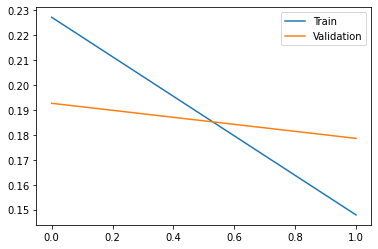

Epoch  1 ; train loss =  tensor(0.1479) ; validation loss =  tensor(0.1786)
Model Saved
Starting epoch 2


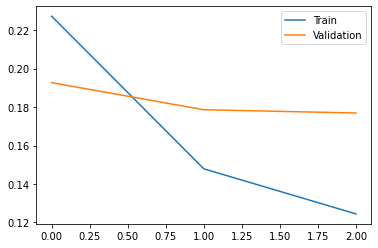

Epoch  2 ; train loss =  tensor(0.1244) ; validation loss =  tensor(0.1769)
Model Saved
Starting epoch 3


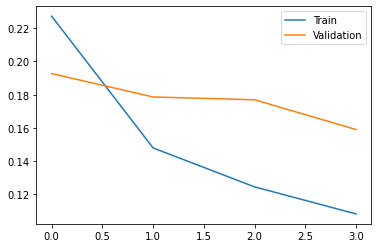

Epoch  3 ; train loss =  tensor(0.1081) ; validation loss =  tensor(0.1590)
Model Saved
Starting epoch 4


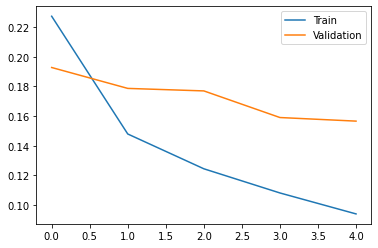

Epoch  4 ; train loss =  tensor(0.0940) ; validation loss =  tensor(0.1566)
Model Saved
Starting epoch 5


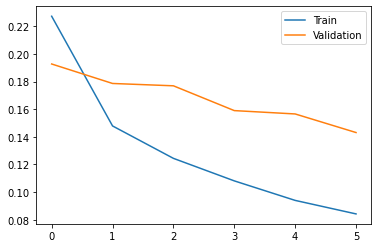

Epoch  5 ; train loss =  tensor(0.0842) ; validation loss =  tensor(0.1431)
Model Saved
Starting epoch 6


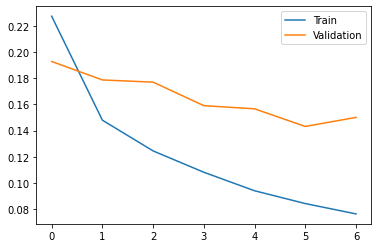

Epoch  6 ; train loss =  tensor(0.0763) ; validation loss =  tensor(0.1500)
Starting epoch 7


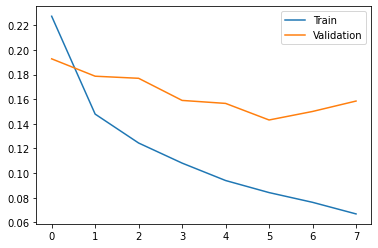

Epoch  7 ; train loss =  tensor(0.0669) ; validation loss =  tensor(0.1585)
Starting epoch 8


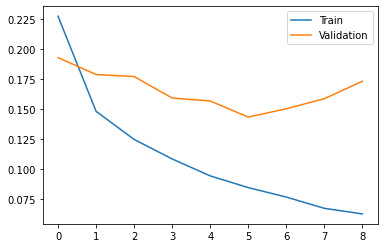

Epoch  8 ; train loss =  tensor(0.0623) ; validation loss =  tensor(0.1730)
Starting epoch 9


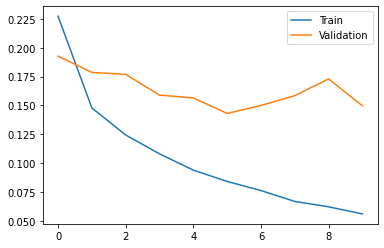

Epoch  9 ; train loss =  tensor(0.0561) ; validation loss =  tensor(0.1498)
Starting epoch 10


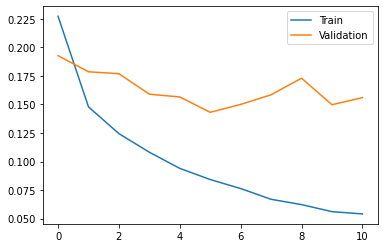

Epoch  10 ; train loss =  tensor(0.0541) ; validation loss =  tensor(0.1560)
Starting epoch 11


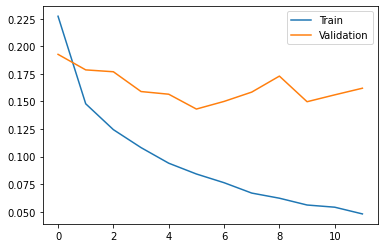

Epoch  11 ; train loss =  tensor(0.0480) ; validation loss =  tensor(0.1620)
Starting epoch 12


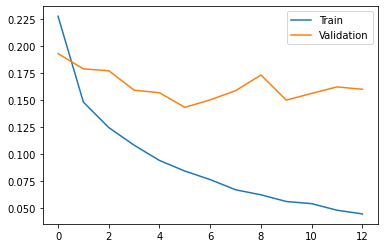

Epoch  12 ; train loss =  tensor(0.0447) ; validation loss =  tensor(0.1598)
Starting epoch 13


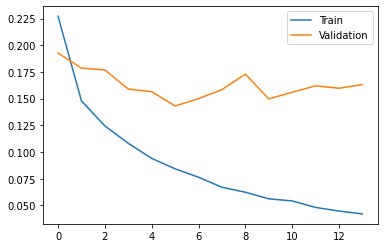

Epoch  13 ; train loss =  tensor(0.0420) ; validation loss =  tensor(0.1632)
Starting epoch 14


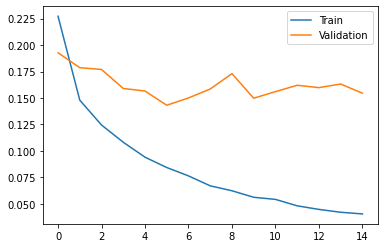

Epoch  14 ; train loss =  tensor(0.0404) ; validation loss =  tensor(0.1545)
Starting epoch 15


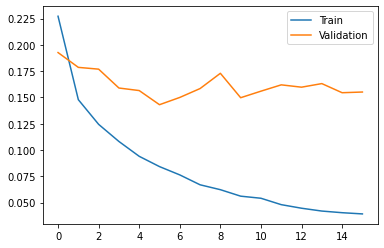

Epoch  15 ; train loss =  tensor(0.0392) ; validation loss =  tensor(0.1552)
Starting epoch 16


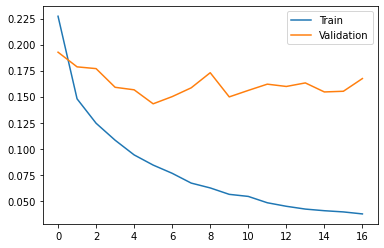

Epoch  16 ; train loss =  tensor(0.0373) ; validation loss =  tensor(0.1674)
Starting epoch 17


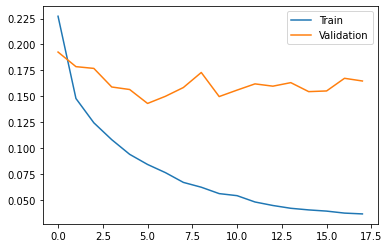

Epoch  17 ; train loss =  tensor(0.0365) ; validation loss =  tensor(0.1648)
Starting epoch 18


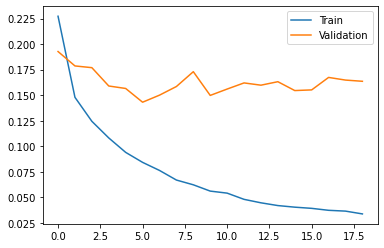

Epoch  18 ; train loss =  tensor(0.0338) ; validation loss =  tensor(0.1636)
Starting epoch 19


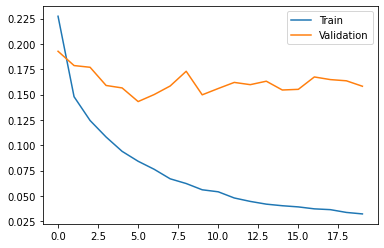

Epoch  19 ; train loss =  tensor(0.0323) ; validation loss =  tensor(0.1582)
Starting epoch 20


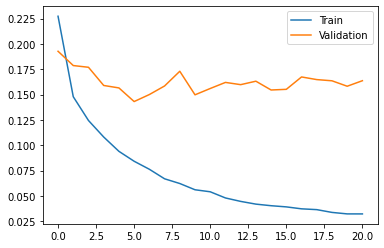

Epoch  20 ; train loss =  tensor(0.0323) ; validation loss =  tensor(0.1637)
Starting epoch 21


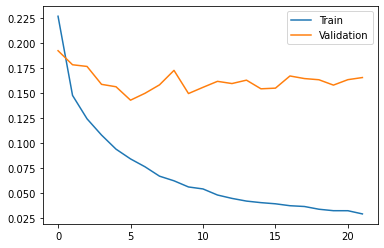

Epoch  21 ; train loss =  tensor(0.0291) ; validation loss =  tensor(0.1658)
Starting epoch 22


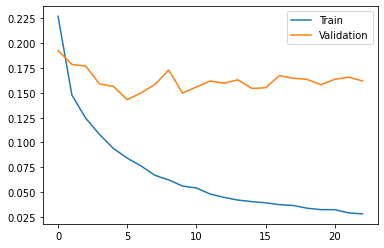

Epoch  22 ; train loss =  tensor(0.0280) ; validation loss =  tensor(0.1621)
Starting epoch 23


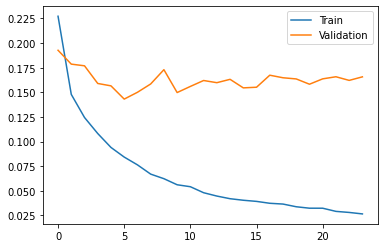

Epoch  23 ; train loss =  tensor(0.0265) ; validation loss =  tensor(0.1657)
Starting epoch 24


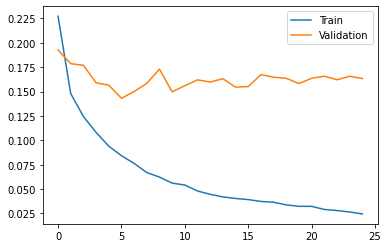

Epoch  24 ; train loss =  tensor(0.0245) ; validation loss =  tensor(0.1634)
Starting epoch 25


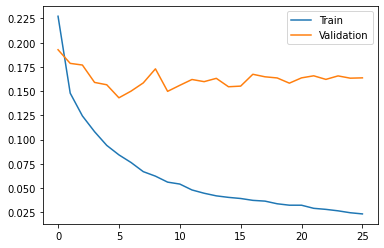

Epoch  25 ; train loss =  tensor(0.0233) ; validation loss =  tensor(0.1637)
Starting epoch 26


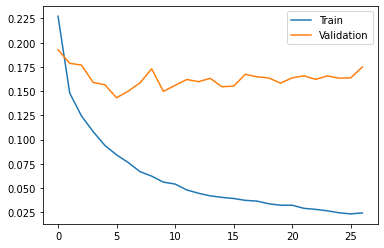

Epoch  26 ; train loss =  tensor(0.0244) ; validation loss =  tensor(0.1750)
Starting epoch 27


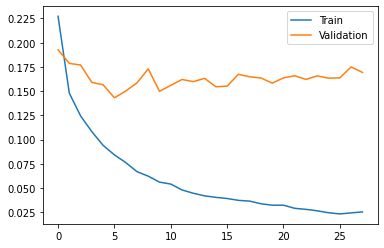

Epoch  27 ; train loss =  tensor(0.0254) ; validation loss =  tensor(0.1693)
Starting epoch 28


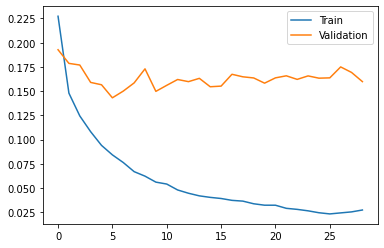

Epoch  28 ; train loss =  tensor(0.0274) ; validation loss =  tensor(0.1598)
Starting epoch 29


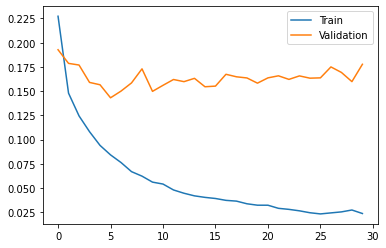

Epoch  29 ; train loss =  tensor(0.0237) ; validation loss =  tensor(0.1777)
Starting epoch 30


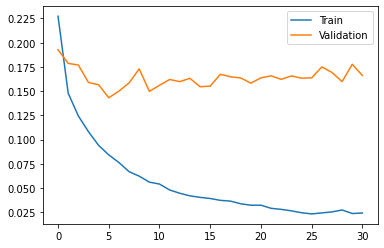

Epoch  30 ; train loss =  tensor(0.0243) ; validation loss =  tensor(0.1661)
Starting epoch 31


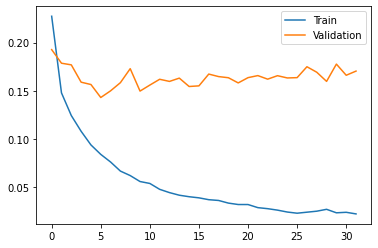

Epoch  31 ; train loss =  tensor(0.0226) ; validation loss =  tensor(0.1705)
Starting epoch 32


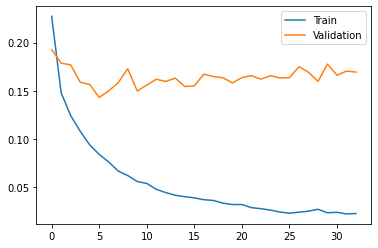

Epoch  32 ; train loss =  tensor(0.0230) ; validation loss =  tensor(0.1694)
Starting epoch 33


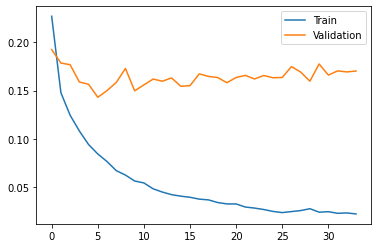

Epoch  33 ; train loss =  tensor(0.0220) ; validation loss =  tensor(0.1703)
Starting epoch 34


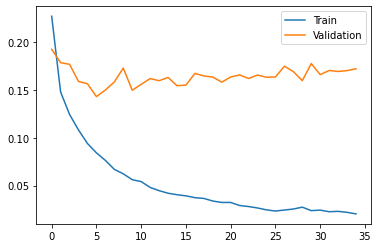

Epoch  34 ; train loss =  tensor(0.0203) ; validation loss =  tensor(0.1722)
Starting epoch 35


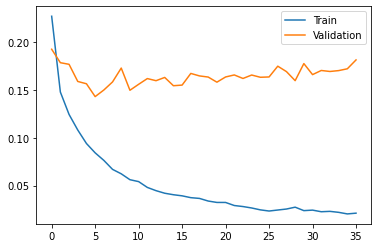

Epoch  35 ; train loss =  tensor(0.0211) ; validation loss =  tensor(0.1815)
Starting epoch 36


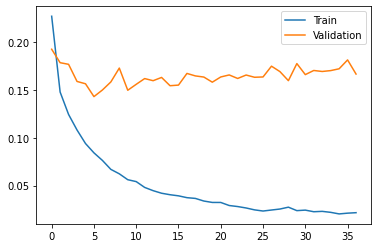

Epoch  36 ; train loss =  tensor(0.0216) ; validation loss =  tensor(0.1667)
Starting epoch 37


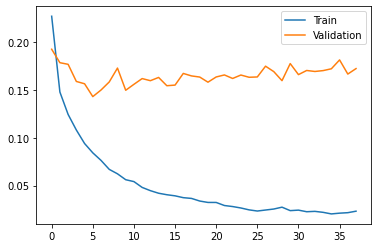

Epoch  37 ; train loss =  tensor(0.0232) ; validation loss =  tensor(0.1725)
Starting epoch 38


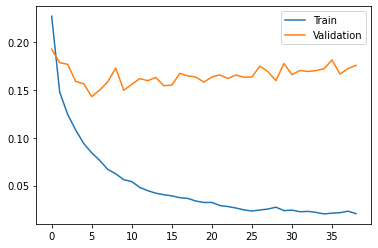

Epoch  38 ; train loss =  tensor(0.0206) ; validation loss =  tensor(0.1758)
Starting epoch 39


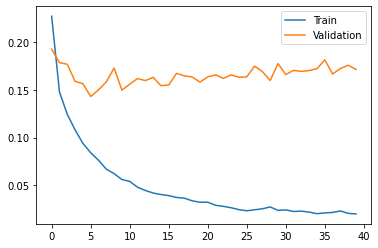

Epoch  39 ; train loss =  tensor(0.0201) ; validation loss =  tensor(0.1715)
Starting epoch 40


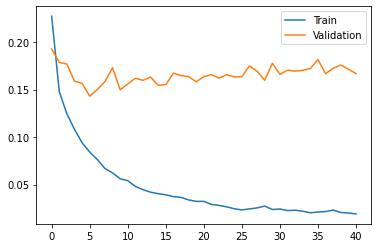

Epoch  40 ; train loss =  tensor(0.0191) ; validation loss =  tensor(0.1669)
Starting epoch 41


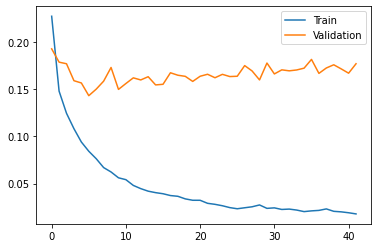

Epoch  41 ; train loss =  tensor(0.0179) ; validation loss =  tensor(0.1769)
Starting epoch 42


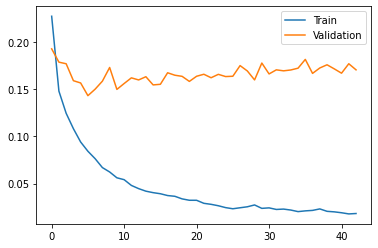

Epoch  42 ; train loss =  tensor(0.0183) ; validation loss =  tensor(0.1705)
Starting epoch 43


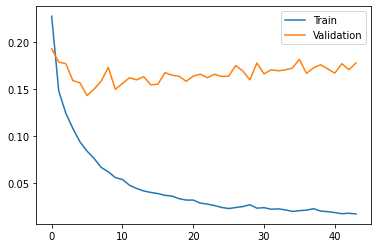

Epoch  43 ; train loss =  tensor(0.0176) ; validation loss =  tensor(0.1778)
Starting epoch 44


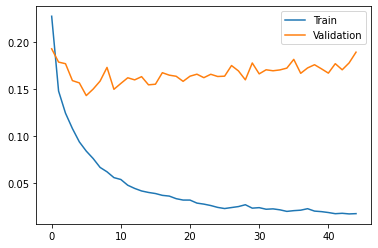

Epoch  44 ; train loss =  tensor(0.0179) ; validation loss =  tensor(0.1892)
Starting epoch 45


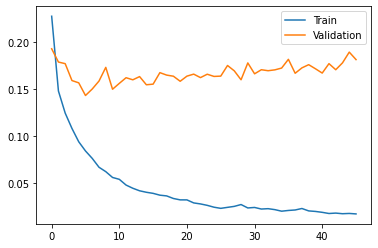

Epoch  45 ; train loss =  tensor(0.0174) ; validation loss =  tensor(0.1812)
Starting epoch 46


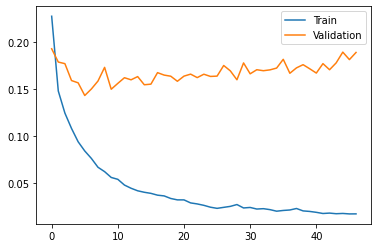

Epoch  46 ; train loss =  tensor(0.0175) ; validation loss =  tensor(0.1888)
Starting epoch 47


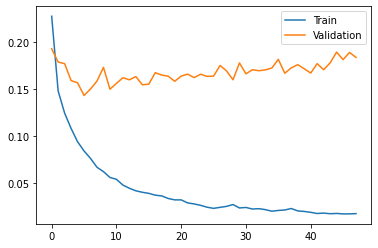

Epoch  47 ; train loss =  tensor(0.0177) ; validation loss =  tensor(0.1835)
Starting epoch 48


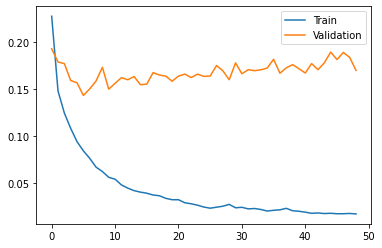

Epoch  48 ; train loss =  tensor(0.0172) ; validation loss =  tensor(0.1697)
Starting epoch 49


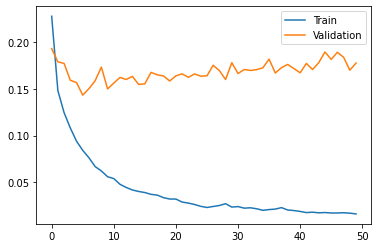

Epoch  49 ; train loss =  tensor(0.0165) ; validation loss =  tensor(0.1774)


In [ ]:
number_epochs = 50
old_best_val_loss=100
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9)

train_loss = []
val_loss = []

for epoch in range(number_epochs):
  print(f"Starting epoch {epoch}")

  if epoch > 0:
    plt.figure()

  model.train()
  train_loss.append(0)
  for images, labels in tqdm(train_loader):
    images = list(image.to(device) for image in images)
    labels = [{k: v.to(device) for k, v in t.items()} for t in labels]

    loss_dict = model(images, labels)
    losses = sum(loss for loss in loss_dict.values())
    optimizer.zero_grad()
    losses.backward()
    optimizer.step() 

    train_loss[epoch] += losses.cpu().data
  train_loss[epoch] /= len(train_dataset)

  if epoch > 0:
    train_plt, = plt.plot(train_loss, label = 'Train')

  val_loss.append(0)
  with torch.no_grad():
    for images, labels in tqdm(val_loader):
      images = list(image.to(device) for image in images)
      labels = [{k: v.to(device) for k, v in t.items()} for t in labels]
      loss_dict = model(images, labels)
      losses = sum(loss for loss in loss_dict.values())
      optimizer.zero_grad()


      val_loss[epoch] += losses.cpu().data
    val_loss[epoch] /= len(val_dataset)

  if epoch > 0:
    val_plt, = plt.plot(val_loss, label = 'Validation')
    plt.legend(handles=[train_plt, val_plt])
    plt.show()
  
  print("Epoch ", epoch, "; train loss = ", train_loss[epoch],"; validation loss = ", val_loss[epoch]) 
  if( val_loss[epoch]<old_best_val_loss):
    old_best_val_loss=val_loss[epoch]
    print("Model Saved") 
    torch.save(model.state_dict(), os.path.join(root_folder, 'model.pt'))

## 6) Evaluate the model
First, we need to load the test set:

In [ ]:
print("Loading test set")
test_dataset = FaceMaskDataset(os.path.join(data_folder, 'images'), os.path.join(data_folder, 'annotations'), test_indexes, conversion=get_transform(False))
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=collate_fn)


Loading test set


**Label Check**

With masks :  680 
Without masks :  127 
Unsure :  19


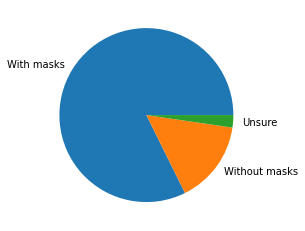

In [34]:
import matplotlib.pyplot as plt

ones=0
twos=0
threes=0
for i in range(len(test_dataset)):
  for lab in test_dataset[i][1]['labels']:
    if lab.item() == 1:
      ones = ones + 1
    if lab.item() == 2:
      twos = twos + 1
    if lab.item() == 3:
      threes = threes + 1

data=[ones,twos,threes]
print('With masks : ',ones,'\nWithout masks : ',twos,'\nUnsure : ',threes)
labs = ['With masks', 'Without masks', 'Unsure'] 
plt.pie(data, labels = labs) 
plt.show() 

**Loading the best model**

In [ ]:
_path = os.path.join(root_folder, 'model.pt')
model.load_state_dict(torch.load(_path))

<All keys matched successfully>

**Prediction method 1**

In [ ]:
test_loss = 0
total_pred = 0
total_true = 0
threshold = 4
correct_with_mask=0
correct_without_mask=0
correct_unsure=0
wrong_actual_with_mask_predicted_without_mask=0
wrong_actual_with_mask_predicted_unsure=0
wrong_actual_without_mask_predicted_with_mask=0
wrong_actual_without_mask_predicted_unsure=0
wrong_actual_unsure_predicted_with_mask=0
wrong_actual_unsure_predicted_without_mask=0

model.eval()
with torch.no_grad():
  for images, labels in tqdm(test_loader):
    images = list(image.to(device) for image in images)
    labels = [{k: v.to(device) for k, v in t.items()} for t in labels]
    pred = model(images)
    for img_idx in range(len(labels)):
      for boxes_true_i in range(len(labels[img_idx]['boxes'])):
        for boxes_pred_i in range(len(pred[img_idx]['boxes'])):
          if (labels[img_idx]['boxes'][boxes_true_i][0] + threshold > pred[img_idx]['boxes'][boxes_pred_i][0] and labels[img_idx]['boxes'][boxes_true_i][0] - threshold < pred[img_idx]['boxes'][boxes_pred_i][0]
              and labels[img_idx]['boxes'][boxes_true_i][1] + threshold > pred[img_idx]['boxes'][boxes_pred_i][1] and labels[img_idx]['boxes'][boxes_true_i][1] - threshold < pred[img_idx]['boxes'][boxes_pred_i][1]
              and labels[img_idx]['boxes'][boxes_true_i][2] + threshold > pred[img_idx]['boxes'][boxes_pred_i][2] and labels[img_idx]['boxes'][boxes_true_i][2] - threshold < pred[img_idx]['boxes'][boxes_pred_i][2]
              and labels[img_idx]['boxes'][boxes_true_i][3] + threshold > pred[img_idx]['boxes'][boxes_pred_i][3] and labels[img_idx]['boxes'][boxes_true_i][3] - threshold < pred[img_idx]['boxes'][boxes_pred_i][3]):
            if(labels[img_idx]['labels'][boxes_true_i]==pred[img_idx]['labels'][boxes_pred_i]==1):
              correct_with_mask+=1
            if(labels[img_idx]['labels'][boxes_true_i]==pred[img_idx]['labels'][boxes_pred_i]==2):
              correct_without_mask+=1
            if(labels[img_idx]['labels'][boxes_true_i]==pred[img_idx]['labels'][boxes_pred_i]==3):
              correct_unsure+=1
            if(labels[img_idx]['labels'][boxes_true_i]==1):
              if(pred[img_idx]['labels'][boxes_pred_i]==2):
                wrong_actual_with_mask_predicted_without_mask+=1
              if(pred[img_idx]['labels'][boxes_pred_i]==3):
                wrong_actual_with_mask_predicted_unsure+=1

            if(labels[img_idx]['labels'][boxes_true_i]==2):
              if(pred[img_idx]['labels'][boxes_pred_i]==1):
                wrong_actual_without_mask_predicted_with_mask+=1
              if(pred[img_idx]['labels'][boxes_pred_i]==3):
                wrong_actual_without_mask_predicted_unsure+=1
            
            if(labels[img_idx]['labels'][boxes_true_i]==3):
              if(pred[img_idx]['labels'][boxes_pred_i]==1):
                wrong_actual_unsure_predicted_with_mask+=1
              if(pred[img_idx]['labels'][boxes_pred_i]==2):
                wrong_actual_unsure_predicted_without_mask+=1

      total_pred=total_pred+len(pred[img_idx]['labels'])
      total_true=total_true+len(labels[img_idx]['labels'])
      
  test_loss += losses.cpu().data



**Prediction method 2**

In [ ]:
'''test_loss = 0
total_pred = 0
total_true = 0
threshold = 10
correct_with_mask=0
correct_without_mask=0
correct_unsure=0
wrong_actual_with_mask_predicted_without_mask=0
wrong_actual_with_mask_predicted_unsure=0
wrong_actual_without_mask_predicted_with_mask=0
wrong_actual_without_mask_predicted_unsure=0
wrong_actual_unsure_predicted_with_mask=0
wrong_actual_unsure_predicted_without_mask=0
wrong_box=0

model.eval()
with torch.no_grad():
  for images, labels in tqdm(test_loader):
    images = list(image.to(device) for image in images)
    labels = [{k: v.to(device) for k, v in t.items()} for t in labels]
    pred = model(images)
    for img_idx in range(len(labels)):
      for boxes_true_i in range(len(labels[img_idx]['boxes'])):
        for boxes_pred_i in range(len(pred[img_idx]['boxes'])):
          cumu=abs(labels[img_idx]['boxes'][boxes_true_i][0]-pred[img_idx]['boxes'][boxes_pred_i][0])+abs(labels[img_idx]['boxes'][boxes_true_i][1]-pred[img_idx]['boxes'][boxes_pred_i][1])+abs(labels[img_idx]['boxes'][boxes_true_i][2]-pred[img_idx]['boxes'][boxes_pred_i][2])+abs(labels[img_idx]['boxes'][boxes_true_i][3]-pred[img_idx]['boxes'][boxes_pred_i][3])
          if (cumu<threshold):
            if(labels[img_idx]['labels'][boxes_true_i]==pred[img_idx]['labels'][boxes_pred_i]==1):
              correct_with_mask+=1
            if(labels[img_idx]['labels'][boxes_true_i]==pred[img_idx]['labels'][boxes_pred_i]==2):
              correct_without_mask+=1
            if(labels[img_idx]['labels'][boxes_true_i]==pred[img_idx]['labels'][boxes_pred_i]==3):
              correct_unsure+=1
            if(labels[img_idx]['labels'][boxes_true_i]==1):
              if(pred[img_idx]['labels'][boxes_pred_i]==2):
                wrong_actual_with_mask_predicted_without_mask+=1
              if(pred[img_idx]['labels'][boxes_pred_i]==3):
                wrong_actual_with_mask_predicted_unsure+=1

            if(labels[img_idx]['labels'][boxes_true_i]==2):
              if(pred[img_idx]['labels'][boxes_pred_i]==1):
                wrong_actual_without_mask_predicted_with_mask+=1
              if(pred[img_idx]['labels'][boxes_pred_i]==3):
                wrong_actual_without_mask_predicted_unsure+=1
            
            if(labels[img_idx]['labels'][boxes_true_i]==3):
              if(pred[img_idx]['labels'][boxes_pred_i]==1):
                wrong_actual_unsure_predicted_with_mask+=1
              if(pred[img_idx]['labels'][boxes_pred_i]==2):
                wrong_actual_unsure_predicted_without_mask+=1

              

            wrong_box=wrong_box+1
      total_pred=total_pred+len(pred[img_idx]['labels'])
      total_true=total_true+len(labels[img_idx]['labels'])
      
  test_loss += losses.cpu().data
'''


**Model evaluation**

In [ ]:
print("True boxes : ",total_pred)
print("'Good boxes' : ",total_true)

print('TEST LOSS : ',test_loss)
print('CONFUSION MATRIX')
print('WIMASK : ',correct_with_mask,'                 ',wrong_actual_without_mask_predicted_with_mask,'                  ',wrong_actual_unsure_predicted_with_mask)
print('WOMASK : ',wrong_actual_with_mask_predicted_without_mask,'                  ',correct_without_mask,'                  ',wrong_actual_unsure_predicted_without_mask)
print('UNSURE : ',wrong_actual_with_mask_predicted_unsure,'                  ',wrong_actual_without_mask_predicted_unsure,'                  ',correct_unsure)


recall_with_mask=correct_with_mask/(correct_with_mask+wrong_actual_with_mask_predicted_without_mask+wrong_actual_with_mask_predicted_unsure)
recall_without_mask=correct_without_mask/(correct_without_mask+wrong_actual_without_mask_predicted_with_mask+wrong_actual_without_mask_predicted_unsure)
recall_unsure=correct_unsure/(correct_unsure+wrong_actual_unsure_predicted_with_mask+wrong_actual_unsure_predicted_without_mask)

precision_with_mask=correct_with_mask/(correct_with_mask+wrong_actual_without_mask_predicted_with_mask+wrong_actual_unsure_predicted_with_mask)
precision_without_mask=correct_without_mask/(correct_without_mask+wrong_actual_with_mask_predicted_without_mask+wrong_actual_unsure_predicted_without_mask)
precision_unsure=correct_unsure/(correct_unsure+wrong_actual_without_mask_predicted_unsure+wrong_actual_with_mask_predicted_unsure)

f1_score_with_mask=2*((recall_with_mask*precision_with_mask)/(recall_with_mask+precision_with_mask))
f1_score_without_mask=2*((recall_without_mask*precision_without_mask)/(recall_without_mask+precision_without_mask))
f1_score_unsure=2*((recall_unsure*precision_unsure)/(recall_unsure+precision_unsure))

accuracy = (correct_with_mask+correct_without_mask+correct_unsure)/(correct_with_mask+correct_without_mask+correct_unsure+wrong_actual_with_mask_predicted_without_mask+
                                                                    wrong_actual_with_mask_predicted_unsure+wrong_actual_without_mask_predicted_with_mask+wrong_actual_without_mask_predicted_unsure+
                                                                    wrong_actual_unsure_predicted_with_mask+wrong_actual_unsure_predicted_without_mask)
print('RECALL : ',recall_with_mask,'  ',recall_without_mask,'              ',recall_unsure)
print('PRECIS : ',precision_with_mask,'  ',precision_without_mask,'  ',precision_unsure)
print('F1-SCO : ',f1_score_with_mask,'  ',f1_score_without_mask,'  ',f1_score_unsure)
print('ACCURA : ',accuracy)

True boxes :  1363
'Good boxes' :  826
TEST LOSS :  tensor(0.3873)
CONFUSION MATRIX
WIMASK :  562                   16                    8
WOMASK :  14                    86                    11
UNSURE :  78                    58                    12
RECALL :  0.8593272171253823    0.5375                0.3870967741935484
PRECIS :  0.9590443686006825    0.7747747747747747    0.08108108108108109
F1-SCO :  0.9064516129032257    0.6346863468634686    0.1340782122905028
ACCURA :  0.7810650887573964
